In [13]:
import torch
import os
import numpy as np
from torch.autograd import Variable
from nets.discriminator import Discriminator
from nets.shift_net import ShiftNet
from skimage.transform import resize

from batch_generator import BatchGenerator

In [14]:
dataset_path = "/data/small_dataset/"

In [15]:
train_data = BatchGenerator(os.path.join(dataset_path, "val_256"))
val_data = BatchGenerator(os.path.join(dataset_path, "val_256"))

In [16]:
img, corrupted_img, mask = val_data.__getitem__(1)

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


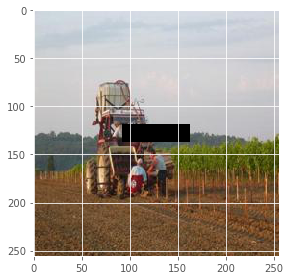

In [17]:
from skimage.io import (imread, imshow)
import matplotlib.pyplot as plt
imshow(corrupted_img)
plt.show()

In [18]:
learning_parametrs = {
    "lr_generator":2e-4,
    "lr_discriminator":2e-4,
    "lambda_adv":Variable(torch.FloatTensor([0.01])),
    "lambda_guidance":Variable(torch.FloatTensor([0.1])),
    "batch_size":1,
    "input_img_size":np.array([256, 256, 3])
}

draw_params = {
    "verbose_every":3,
    "draw_every":5
}

In [19]:
def get_batch(data):
    max_size = len(data)
    xb = []
    yb = []
    maskb = []
    eps = 1e-6
    for i in range(learning_parametrs["batch_size"]):
        x, y, mask = data[np.random.randint(0, max_size)]
        x = resize(x, learning_parametrs["input_img_size"]).transpose(2, 0, 1)

        x += eps
        x /= x.max()
        
        y = resize(y, learning_parametrs["input_img_size"]).transpose(2, 0, 1)
        y += eps
        y /= y.max()
        xb.append(x)
        yb.append(y)
        maskb.append(mask)
    return torch.FloatTensor(np.array(xb)), torch.FloatTensor(np.array(yb)), maskb

In [29]:
#generator = сетка Антона
generator = ShiftNet()
discriminator = Discriminator()
torch.nn.DataParallel(generator).cuda()
torch.nn.DataParallel(discriminator).cuda()
l2_loss_object = torch.nn.MSELoss()
l1_loss_object = torch.nn.L1Loss()
bce_loss = torch.nn.BCELoss()
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_parametrs["lr_generator"])
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_parametrs["lr_discriminator"])

In [48]:
def get_losses(x, y, mask, generator, discriminator):
    #print("!!")
    x = Variable(x)
    y = Variable(y)
    x = x.cuda()
    y = y.cuda()
    res = generator(x, mask)
    gt_features = generator.first32_output
    generator(y, mask);
    corrupted_img_features = generator.second32_output
    #loss_guidance = l2_loss_object(gt_features, corrupted_img_features)
    loss_l1 = l1_loss_object(res, y)
    discriminator_gt_output = discriminator(x)
    discriminator_corrupted_output = discriminator(y)
    loss_adv = (bce_loss(discriminator_corrupted_output, Variable(torch.zeros(discriminator_corrupted_output.shape[0])).cuda())
             + bce_loss(discriminator_gt_output, Variable(torch.ones(discriminator_gt_output.shape[0])).cuda()))
    common_loss_generator = loss_l1 - learning_parametrs["lambda_adv"].cuda() * loss_adv #+ learning_parametrs["lambda_guidance"] * loss_guidance
    discriminator_loss = loss_adv
    
    return common_loss_generator, discriminator_loss

In [49]:
from IPython.display import clear_output
plt.style.use("ggplot")
def draw_losses(loss_train_history, loss_val_history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    
    ax[0].semilogy(loss_train_history["generator"], label="train log loss generator")
    ax[0].semilogy(loss_val_history["generator"], label="val log loss generator")
    ax[0].legend(loc="best")
    ax[0].set_title("generator loss")
    
    ax[1].semilogy(loss_train_history["discriminator"], label="train log loss discriminator")
    ax[1].semilogy(loss_val_history["discriminator"], label="val log loss discriminator")
    ax[1].legend(loc="best")
    ax[1].set_title("discriminator loss")
    plt.show()
    

In [50]:
from tqdm import tqdm
def train(epoch_num, start_iteration=0):
    iteration = start_iteration
    loss_train_history = {
        "discriminator":[],
        "generator":[],
    }
    loss_val_history = {
        "discriminator":[],
        "generator":[],
    }
    
    for _ in tqdm(range(epoch_num)):
        torch.cuda.empty_cache()
        iteration += 1
        x, y, mask = get_batch(train_data)
        mask = mask[0].reshape((32, 32))
        common_loss_generator, discriminator_loss = get_losses(x, y, mask, generator, discriminator)
        
        if iteration % 2:
            optimizer_generator.zero_grad()
            common_loss_generator.backward()
            optimizer_generator.step()
        if iteration % 2 == 0:
            optimizer_discriminator.zero_grad()
            discriminator_loss.backward()
            optimizer_discriminator.step()
        
        if iteration % draw_params["verbose_every"] == 0:
            loss_train_history["discriminator"].append(discriminator_loss.cpu().data.numpy()[0])
            loss_train_history["generator"].append(common_loss_generator.cpu().data.numpy()[0])
            
            x, y, mask = get_batch(val_data)
            mask = mask[0].reshape((32, 32))
            common_loss_generator, discriminator_loss = get_losses(x, y, mask, generator, discriminator)
            
            loss_val_history["discriminator"].append(discriminator_loss.cpu().data.numpy()[0])
            loss_val_history["generator"].append(common_loss_generator.cpu().data.numpy()[0])
            
            clear_output()
            draw_losses(loss_train_history, loss_val_history)
            

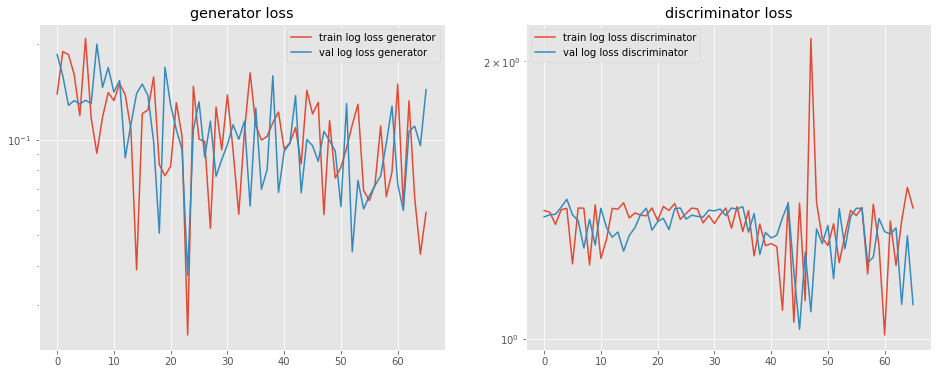

100%|██████████| 200/200 [02:06<00:00,  1.58it/s]


In [51]:
train(200)